# Mushroom Toxicity Prediction: Multi-Modal Analysis

This notebook performs a comprehensive EDA and builds an intensive multi-modal model that fuses vision and tabular data to predict mushroom toxicity.

## Objectives:
1. Comprehensive EDA of tabular features
2. Deep analysis of mushroom images (colors, size, texture)
3. Correlation analysis between visual/tabular characteristics and toxicity
4. Multi-modal fusion model combining vision and tabular data

In [3]:
pip install torch torchvision scikit-learn pandas numpy matplotlib seaborn opencv-python pillow 

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\bonit\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

# Sklearn for preprocessing and metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Download and Setup

In [9]:
pip install kaggle unzip

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1306 sha256=d5b6fd1eec025eaf3a87b4f0efb6031959e164916457f86674454707d050734b
  Stored in directory: c:\users\bonit\appdata\local\pip\cache\wheels\3c\4d\b3\ddd83a91322fba02a91898d3b006090d1df1d3b0ad61bd8b36
Successfully built unzip
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\bonit\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [13]:
# Download competition data (Windows-safe extraction)
from pathlib import Path
from zipfile import ZipFile
import subprocess

zip_path = Path('selection-ofia-2025.zip')
if not zip_path.exists():
    print('Zip not found locally. Downloading from Kaggle...')
    subprocess.run(['kaggle', 'competitions', 'download', '-c', 'selection-ofia-2025', '-f', 'selection-ofia-2025.zip', '-p', '.'], check=True)
    zip_path = Path('selection-ofia-2025.zip')

with ZipFile(zip_path, 'r') as zf:
    zf.extractall('.')
print('Archive extracted to current directory.')

Archive extracted to current directory.


In [1]:
# Check downloaded files (cross-platform)
from pathlib import Path
print('Top-level files/folders:')
for p in sorted(Path('.').iterdir()):
    print(('DIR ' if p.is_dir() else 'FILE'), p.name)

Top-level files/folders:
FILE mushroom_toxicity_analysis.ipynb
DIR  OFIA_2025_epreuve_1
FILE selection-ofia-2025.zip


## 2. Load and Explore Tabular Data

In [ ]:

def resolve_csv(filename: str) -> Path:
    p = Path(filename)
    if p.exists():
        return p
    matches = list(Path('.').rglob(filename))
    if matches:
        print(f"Found {filename} at: {matches[0]}")
        return matches[0]
  

# If you still have the zip but not the CSVs, extract once:
zip_path = Path('selection-ofia-2025.zip')
if zip_path.exists() and not Path('X_train.csv').exists():
    from zipfile import ZipFile
    with ZipFile(zip_path, 'r') as zf:
        zf.extractall('.')
    print("Extracted zip to current directory.")

X_train = pd.read_csv(resolve_csv('X_train.csv'))
y_train = pd.read_csv(resolve_csv('y_train.csv'))
X_test  = pd.read_csv(resolve_csv('X_test.csv'))

print(f"Training set shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}")

train_data = pd.merge(X_train, y_train, on='id')
print(f"\nMerged training data shape: {train_data.shape}")

Extracted zip to current directory.
Found X_train.csv at: OFIA_2025_epreuve_1\X_train.csv
Found y_train.csv at: OFIA_2025_epreuve_1\y_train.csv
Found X_test.csv at: OFIA_2025_epreuve_1\X_test.csv
Training set shape: (10000, 14)
Training labels shape: (10000, 2)
Test set shape: (5000, 14)

Merged training data shape: (10000, 15)


In [9]:
# Display basic information about the dataset
print("=== TRAINING DATA INFO ===")
print(train_data.info())
print("\n=== FIRST 5 ROWS ===")
train_data.head()

=== TRAINING DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              10000 non-null  int64  
 1   x                               10000 non-null  float64
 2   y                               10000 non-null  float64
 3   poids                           10000 non-null  float64
 4   odeur                           10000 non-null  object 
 5   texture                         10000 non-null  object 
 6   type_sol                        10000 non-null  object 
 7   porosite                        10000 non-null  float64
 8   ph_du_jus                       10000 non-null  float64
 9   ph_du_sol                       10000 non-null  float64
 10  temperature_du_sol              10000 non-null  float64
 11  presence_insecte                10000 non-null  object 
 12  effet_

,id,x,y,poids,odeur,texture,type_sol,porosite,ph_du_jus,ph_du_sol,temperature_du_sol,presence_insecte,effet_au_toucher,a_l_air_delicieux_selon_renard,est_toxique
0,1,46.518521,92.119885,88.308307,fruitée,rugueux,eau,0.741929,7.335818,5.794626,6.455303,non,picottement,oui,0
1,2,102.241703,35.135201,96.590908,terreuse,visqueux,eau,0.389519,7.061616,6.104442,15.365891,non,irritation,oui,0
2,3,98.422446,45.970688,120.342996,fruitée,rugueux,roche,0.752773,8.290888,6.310928,14.846650,oui,irritation,oui,0
3,4,95.127541,34.404093,126.587746,fruitée,rugueux,terre,0.721244,7.415450,6.778531,24.521058,non,irritation,oui,0
4,5,99.334455,39.350139,75.401382,épicée,lisse,arbre,0.932372,7.392589,6.786218,29.464864,non,aucun,non,0


In [10]:
# Check for missing values
print("=== MISSING VALUES ===")
missing_values = train_data.isnull().sum()
print(missing_values[missing_values > 0])

print("\n=== BASIC STATISTICS ===")
train_data.describe()

=== MISSING VALUES ===
Series([], dtype: int64)

=== BASIC STATISTICS ===


,id,x,y,poids,porosite,ph_du_jus,ph_du_sol,temperature_du_sol,est_toxique
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,79.011780,61.040212,100.183722,0.497860,7.229296,6.506125,15.880173,0.349400
std,2886.89568,40.482307,42.004295,20.041428,0.286630,1.029837,1.178774,6.762517,0.476804
min,1.00000,-13.506382,-12.861071,16.980442,0.000003,3.374836,2.574527,0.704821,0.000000
25%,2500.75000,46.878515,36.859544,86.976690,0.250262,6.598209,5.709480,10.906157,0.000000
50%,5000.50000,89.868954,46.359024,100.106868,0.496270,7.195873,6.432121,15.269221,0.000000
75%,7500.25000,96.084915,88.045087,113.466051,0.746851,7.871094,7.246326,20.196052,1.000000
max,10000.00000,202.536846,202.471350,180.120401,0.999897,11.495700,11.828835,46.594349,1.000000


## 3. Comprehensive EDA - Target Variable Analysis

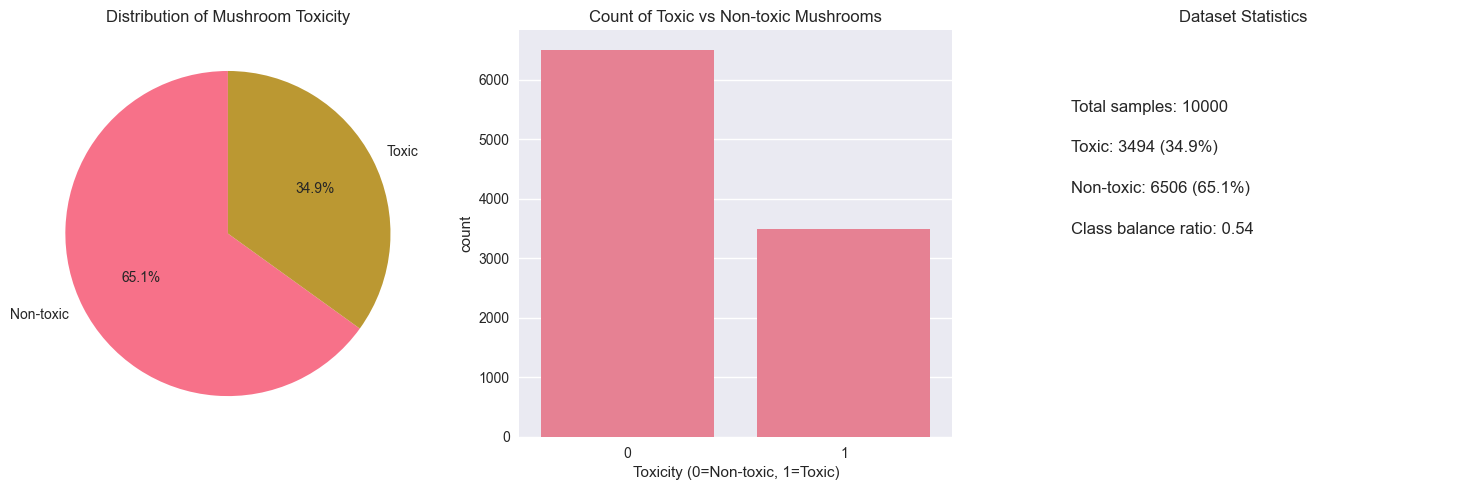

Toxicity distribution:
est_toxique
0    6506
1    3494
Name: count, dtype: int64


In [11]:
# Analyze target variable distribution
plt.figure(figsize=(15, 5))

# Toxicity distribution
plt.subplot(1, 3, 1)
toxicity_counts = train_data['est_toxique'].value_counts()
plt.pie(toxicity_counts.values, labels=['Non-toxic', 'Toxic'], autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Mushroom Toxicity')

# Bar plot
plt.subplot(1, 3, 2)
sns.countplot(data=train_data, x='est_toxique')
plt.title('Count of Toxic vs Non-toxic Mushrooms')
plt.xlabel('Toxicity (0=Non-toxic, 1=Toxic)')

# Statistics
plt.subplot(1, 3, 3)
plt.text(0.1, 0.8, f"Total samples: {len(train_data)}", fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.7, f"Toxic: {toxicity_counts[1]} ({toxicity_counts[1]/len(train_data)*100:.1f}%)", 
         fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.6, f"Non-toxic: {toxicity_counts[0]} ({toxicity_counts[0]/len(train_data)*100:.1f}%)", 
         fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.5, f"Class balance ratio: {toxicity_counts[1]/toxicity_counts[0]:.2f}", 
         fontsize=12, transform=plt.gca().transAxes)
plt.axis('off')
plt.title('Dataset Statistics')

plt.tight_layout()
plt.show()

print(f"Toxicity distribution:\n{toxicity_counts}")

## 4. Numerical Features Analysis

In [12]:
# Identify numerical and categorical columns
numerical_cols = ['x', 'y', 'poids', 'porosite', 'ph_du_jus', 'ph_du_sol', 'temperature_du_sol']
categorical_cols = ['odeur', 'texture', 'type_sol', 'presence_insecte', 'effet_au_toucher', 
                   'a_l_air_delicieux_selon_renard']

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

Numerical columns: ['x', 'y', 'poids', 'porosite', 'ph_du_jus', 'ph_du_sol', 'temperature_du_sol']
Categorical columns: ['odeur', 'texture', 'type_sol', 'presence_insecte', 'effet_au_toucher', 'a_l_air_delicieux_selon_renard']


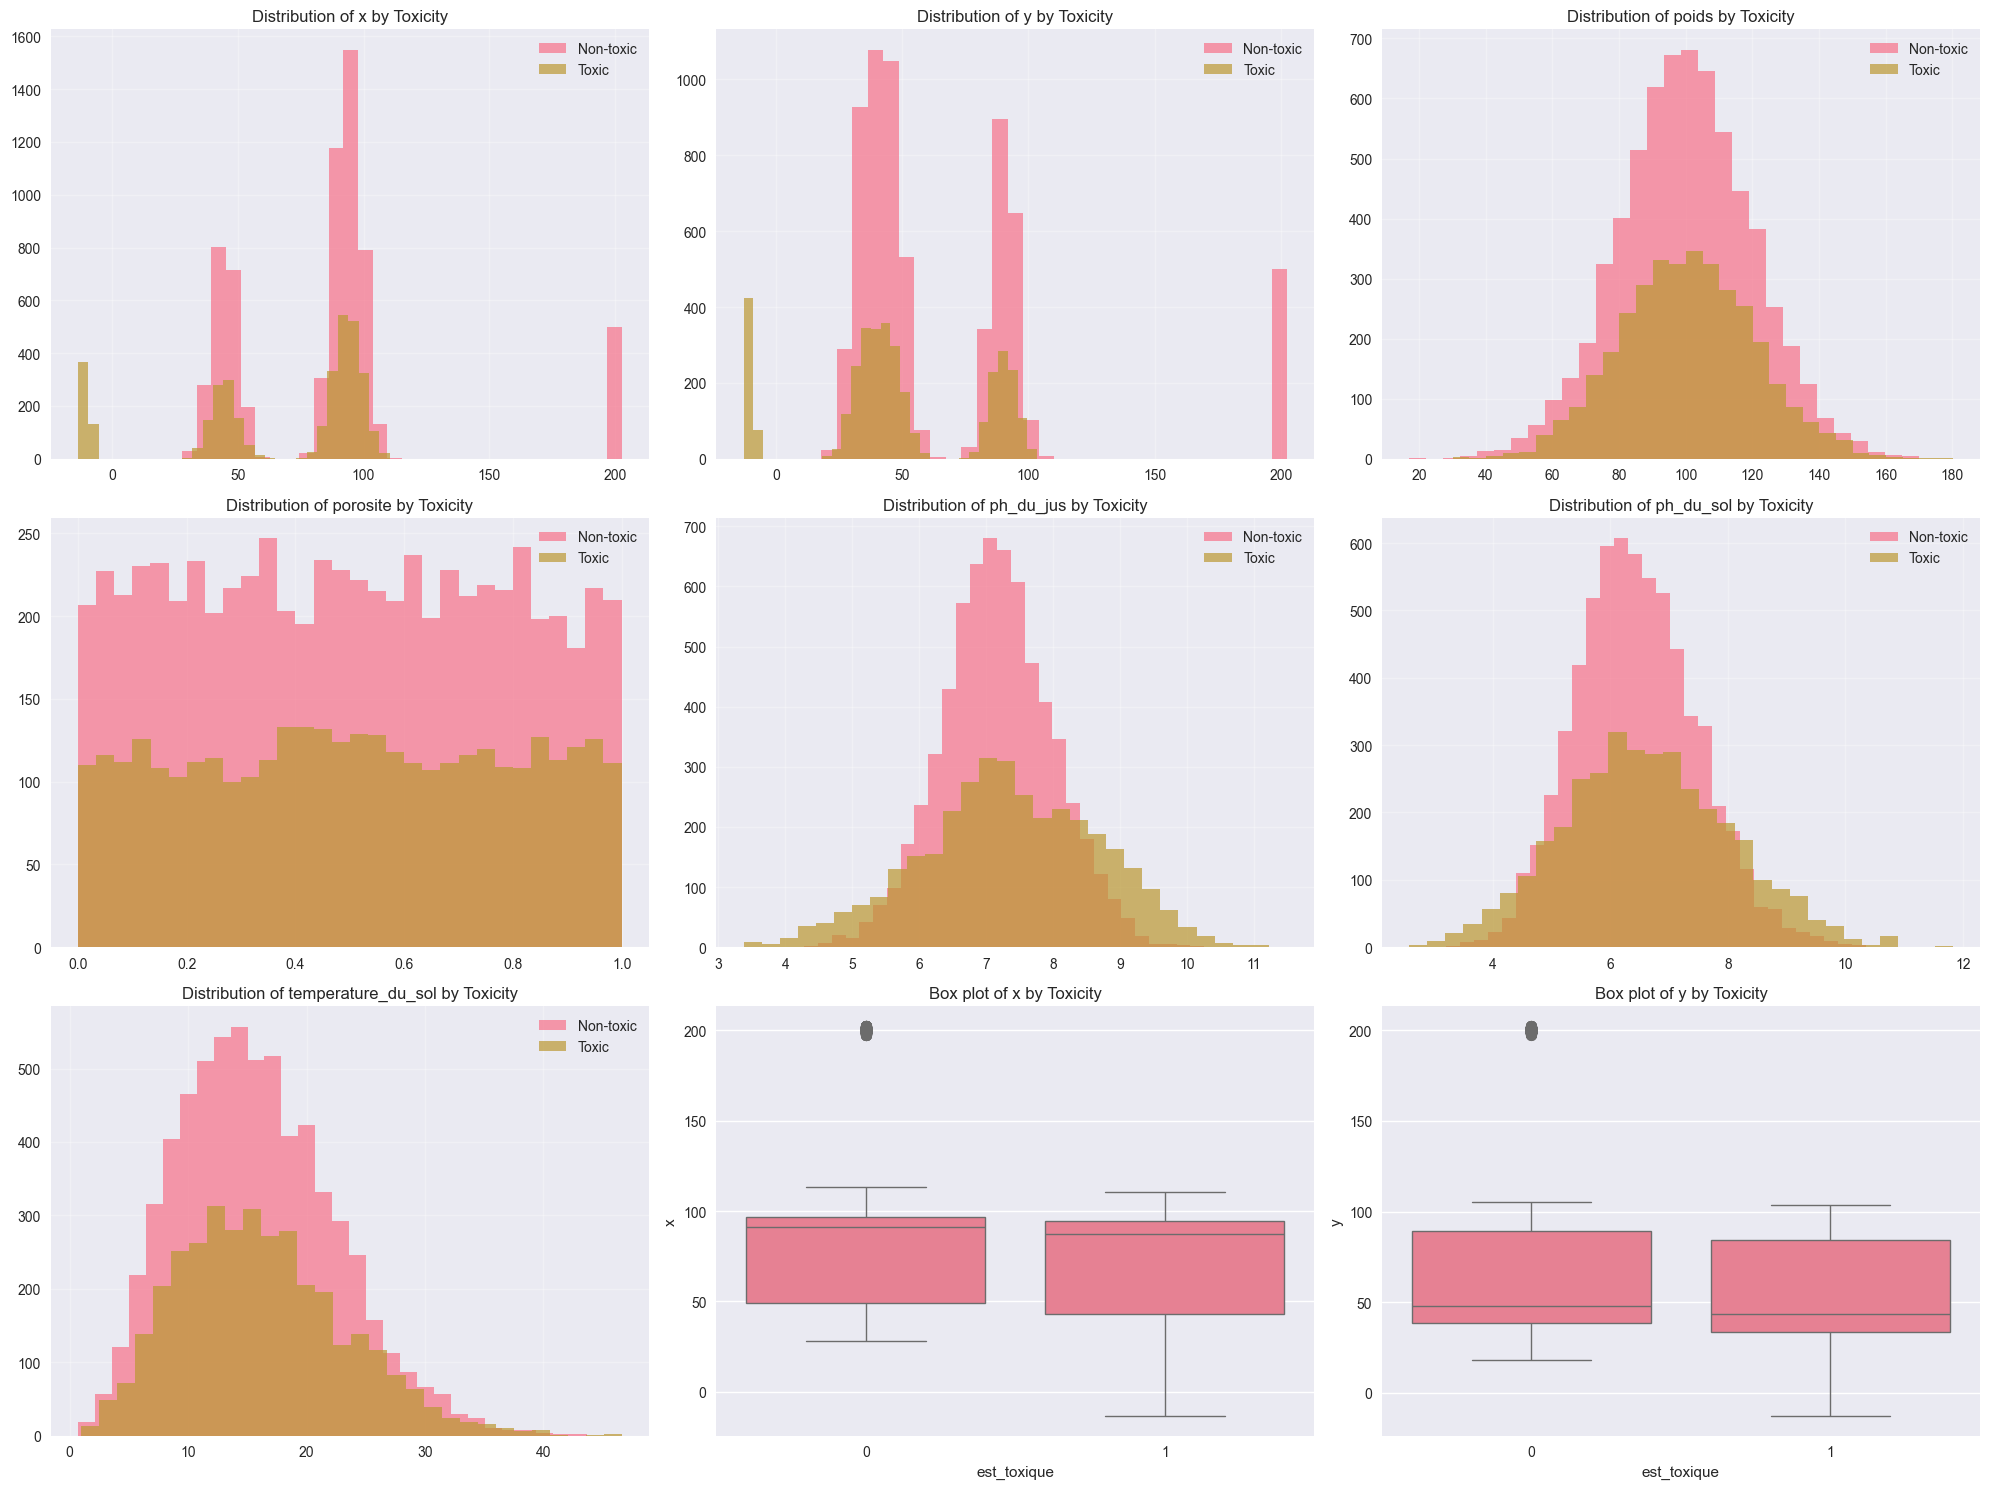

In [13]:
# Analyze numerical features
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    # Distribution by toxicity
    axes[i].hist(train_data[train_data['est_toxique']==0][col], alpha=0.7, label='Non-toxic', bins=30)
    axes[i].hist(train_data[train_data['est_toxique']==1][col], alpha=0.7, label='Toxic', bins=30)
    axes[i].set_title(f'Distribution of {col} by Toxicity')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Box plots for remaining spaces
for i in range(len(numerical_cols), len(axes)):
    if i-len(numerical_cols) < len(numerical_cols):
        col = numerical_cols[i-len(numerical_cols)]
        sns.boxplot(data=train_data, x='est_toxique', y=col, ax=axes[i])
        axes[i].set_title(f'Box plot of {col} by Toxicity')
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Check image directories (robust resolution)
from pathlib import Path

def resolve_image_dir(kind: str) -> str:
    # 1) Preferred default: images/train or images/test
    default = Path('images') / kind
    if default.exists():
        return str(default)

    # 2) Any ".../images/<kind>" path containing PNGs
    for images_dir in Path('.').rglob('images'):
        candidate = images_dir / kind
        if candidate.exists() and any(candidate.glob('*.png')):
            return str(candidate)

    # 3) Any directory named <kind> that contains PNGs
    for candidate in Path('.').rglob(kind):
        if candidate.is_dir() and any(candidate.glob('*.png')):
            return str(candidate)


    

train_img_dir = resolve_image_dir('train')
test_img_dir = resolve_image_dir('test')

print(f"Resolved train_img_dir: {train_img_dir}")
print(f"Resolved test_img_dir:  {test_img_dir}")

# Quick counts
def count_pngs(d):
    p = Path(d)
    return len(list(p.glob('*.png'))) if p.exists() else 0

print(f"Train images directory exists: {Path(train_img_dir).exists()} | PNGs: {count_pngs(train_img_dir)}")
print(f"Test images directory exists:  {Path(test_img_dir).exists()}  | PNGs: {count_pngs(test_img_dir)}")

Resolved train_img_dir: OFIA_2025_epreuve_1\images\train
Resolved test_img_dir:  OFIA_2025_epreuve_1\images\test
Train images directory exists: True | PNGs: 10000
Test images directory exists:  True  | PNGs: 5000


## 5. Categorical Features Analysis

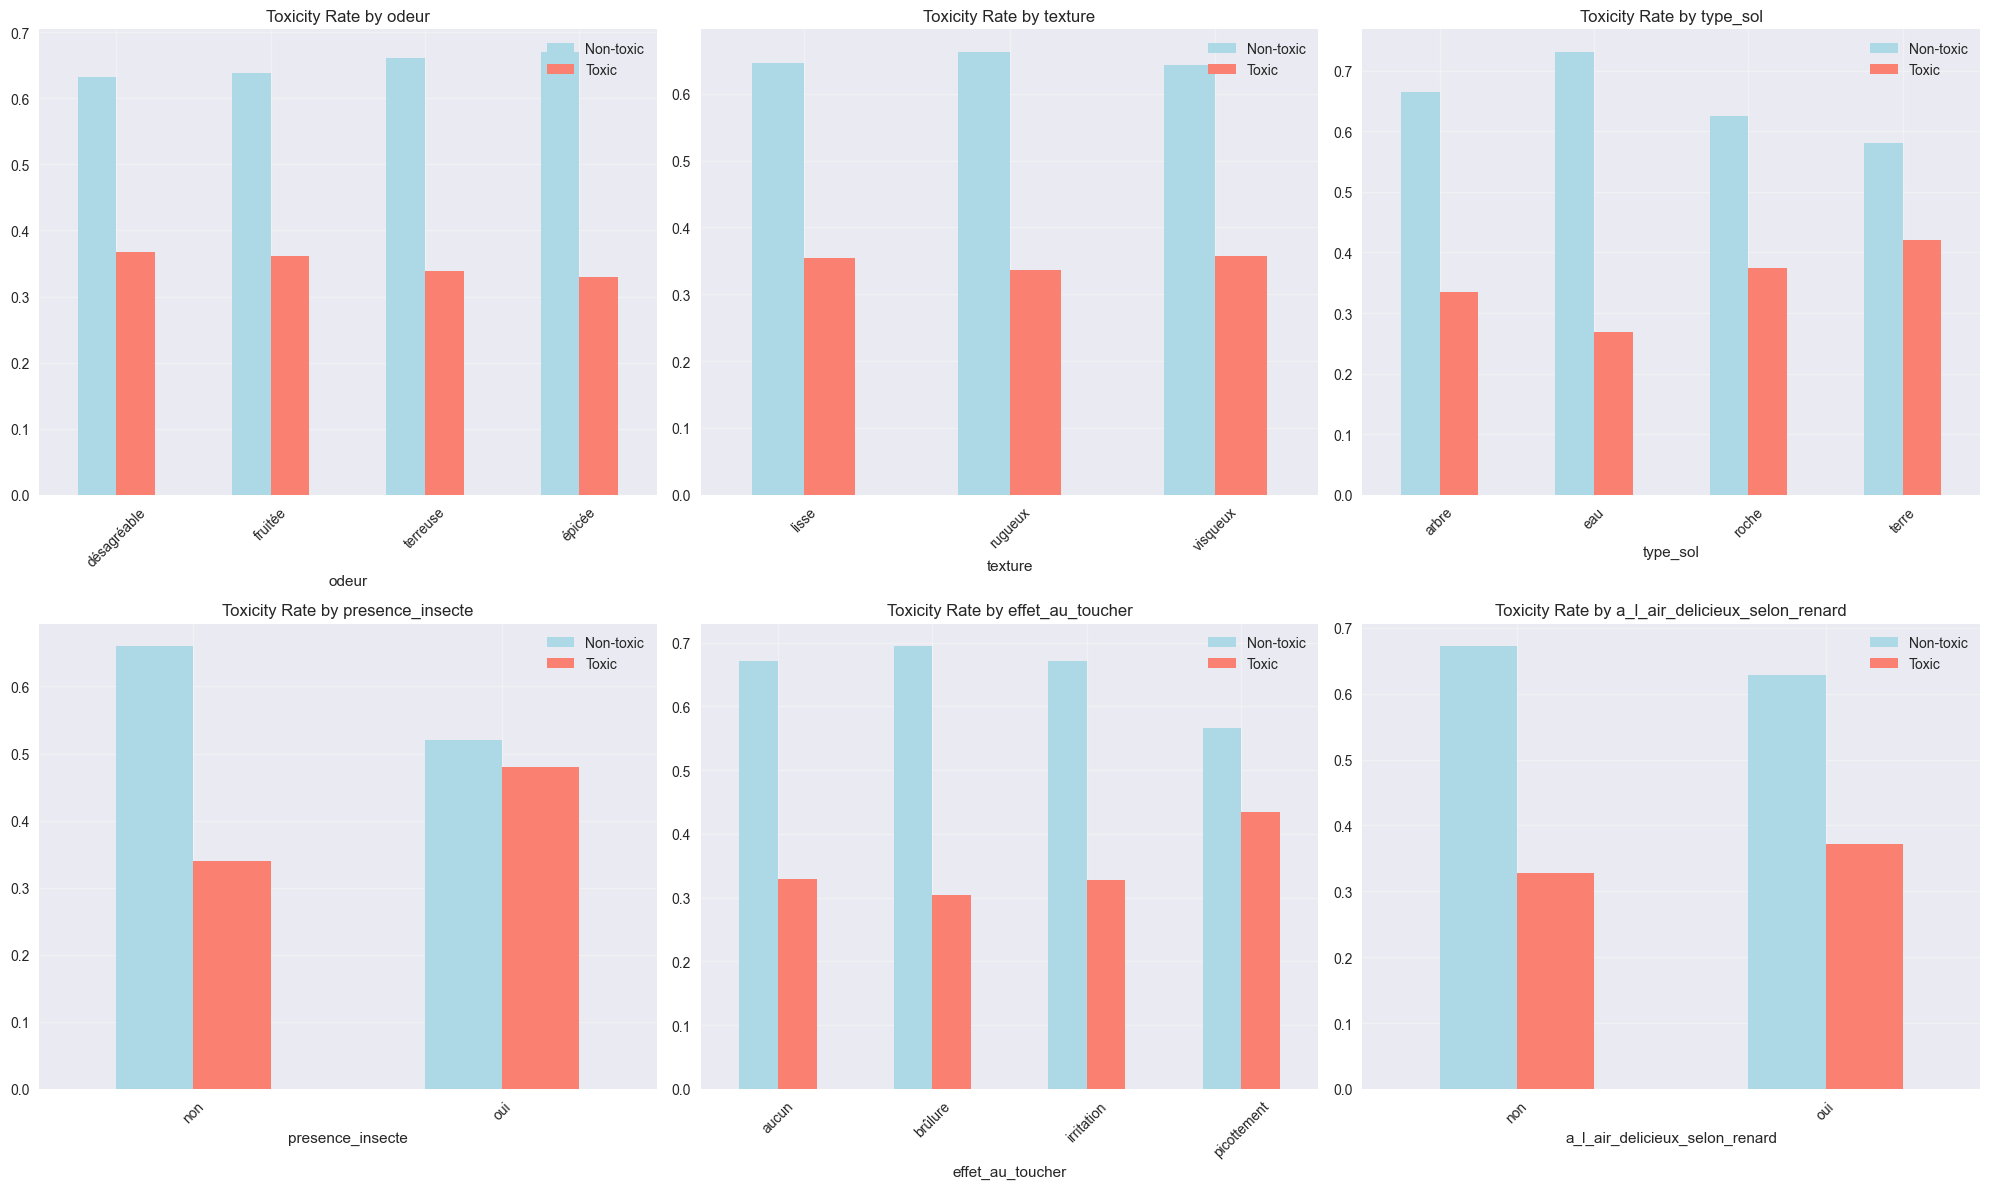

In [14]:
# Analyze categorical features
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, col in enumerate(categorical_cols):
    # Create contingency table
    ct = pd.crosstab(train_data[col], train_data['est_toxique'], normalize='index')
    
    # Plot stacked bar chart
    ct.plot(kind='bar', ax=axes[i], color=['lightblue', 'salmon'])
    axes[i].set_title(f'Toxicity Rate by {col}')
    axes[i].legend(['Non-toxic', 'Toxic'])
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Detailed analysis of each categorical feature
for col in categorical_cols:
    print(f"\n=== {col.upper()} ANALYSIS ===")
    
    # Value counts
    print(f"Unique values: {train_data[col].unique()}")
    print(f"Value counts:")
    print(train_data[col].value_counts())
    
    # Toxicity rate by category
    toxicity_by_cat = train_data.groupby(col)['est_toxique'].agg(['count', 'sum', 'mean']).round(3)
    toxicity_by_cat.columns = ['Total', 'Toxic_Count', 'Toxicity_Rate']
    print(f"\nToxicity rates:")
    print(toxicity_by_cat)
    print("-" * 50)


=== ODEUR ANALYSIS ===
Unique values: ['fruitée' 'terreuse' 'épicée' 'désagréable']
Value counts:
odeur
épicée         2535
fruitée        2518
terreuse       2509
désagréable    2438
Name: count, dtype: int64

Toxicity rates:
             Total  Toxic_Count  Toxicity_Rate
odeur                                         
désagréable   2438          897          0.368
fruitée       2518          911          0.362
terreuse      2509          851          0.339
épicée        2535          835          0.329
--------------------------------------------------

=== TEXTURE ANALYSIS ===
Unique values: ['rugueux' 'visqueux' 'lisse']
Value counts:
texture
visqueux    3346
rugueux     3334
lisse       3320
Name: count, dtype: int64

Toxicity rates:
          Total  Toxic_Count  Toxicity_Rate
texture                                    
lisse      3320         1175          0.354
rugueux    3334         1123          0.337
visqueux   3346         1196          0.357
-------------------------------

## 6. Correlation Analysis

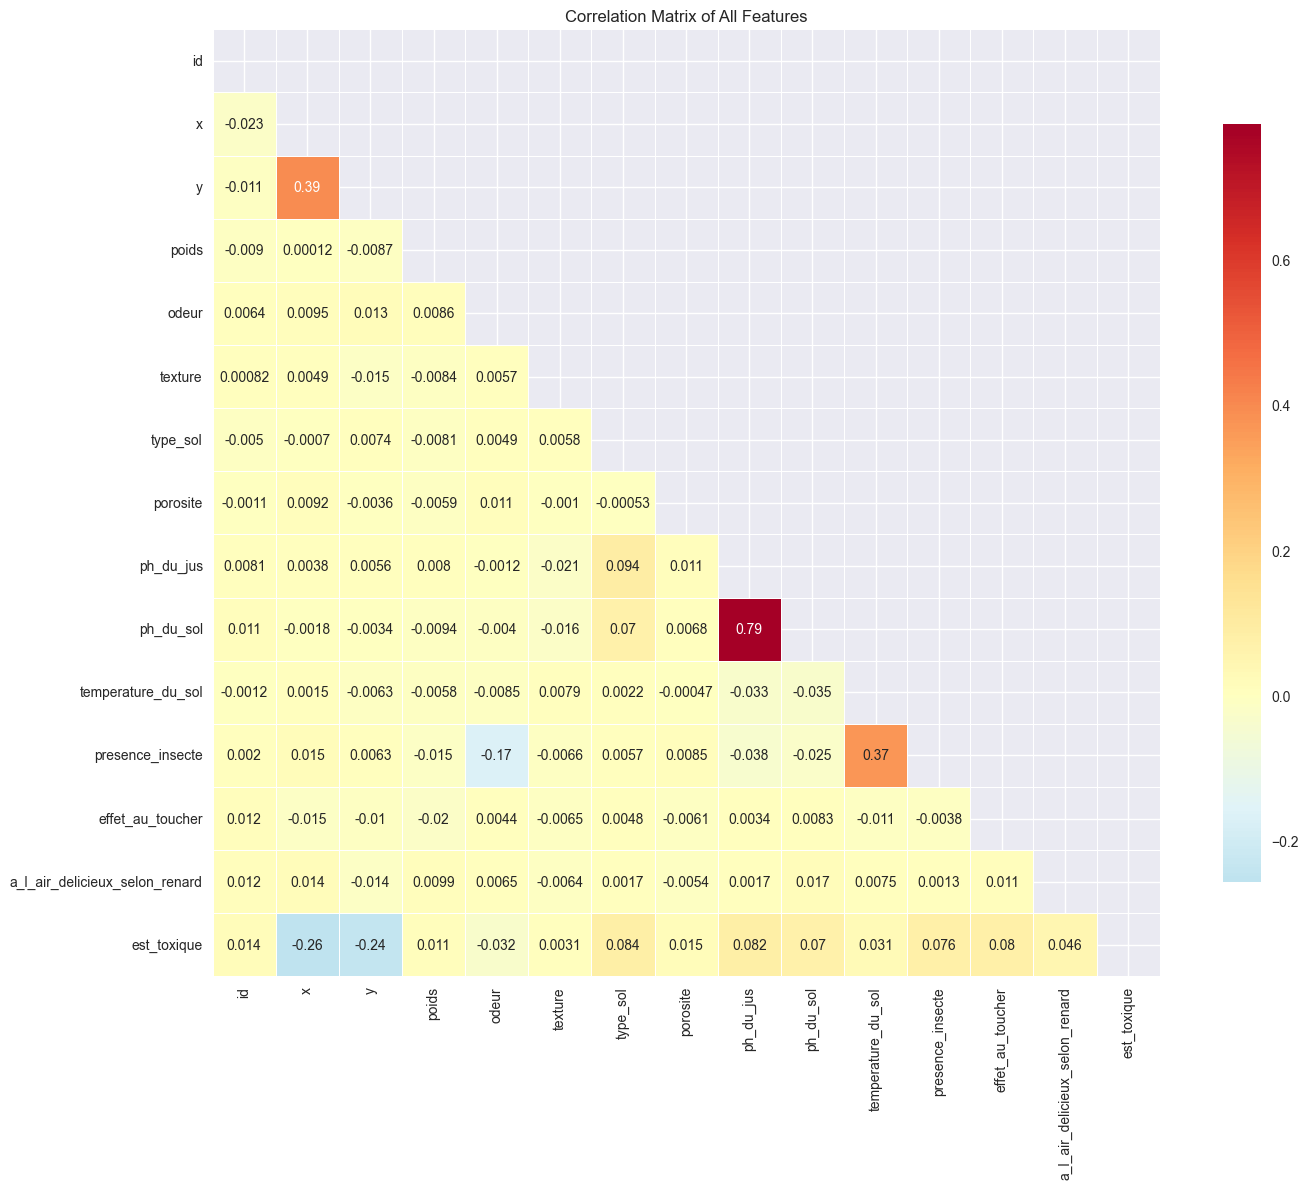

In [16]:
# Prepare data for correlation analysis
# Encode categorical variables
train_encoded = train_data.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_encoded[col] = le.fit_transform(train_encoded[col])
    label_encoders[col] = le

# Calculate correlation matrix
correlation_matrix = train_encoded.corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of All Features')
plt.tight_layout()
plt.show()

=== CORRELATIONS WITH TOXICITY (Absolute Values) ===
est_toxique                       1.000000
x                                 0.256334
y                                 0.237572
type_sol                          0.084426
ph_du_jus                         0.081903
effet_au_toucher                  0.079906
presence_insecte                  0.076291
ph_du_sol                         0.069798
a_l_air_delicieux_selon_renard    0.046436
odeur                             0.032389
temperature_du_sol                0.030580
porosite                          0.014675
id                                0.014003
poids                             0.010749
texture                           0.003061
Name: est_toxique, dtype: float64


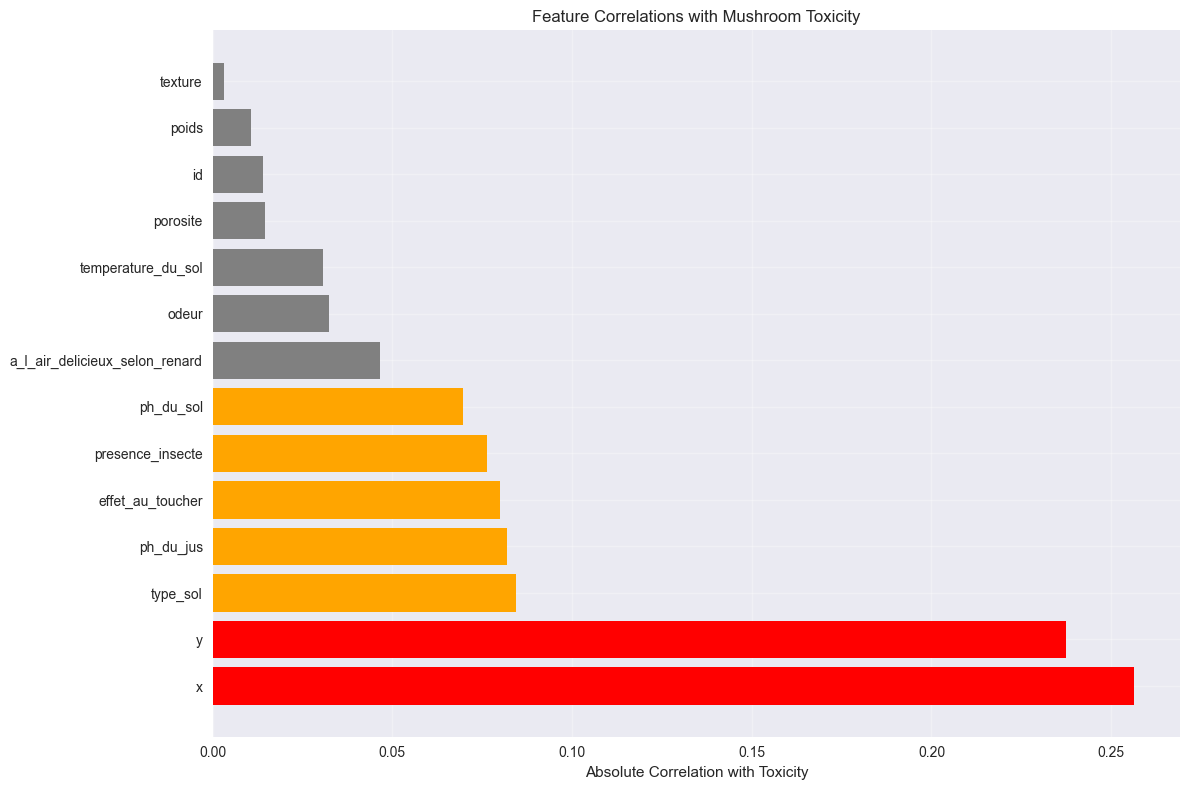

In [17]:
# Focus on correlations with toxicity
toxicity_correlations = correlation_matrix['est_toxique'].abs().sort_values(ascending=False)
print("=== CORRELATIONS WITH TOXICITY (Absolute Values) ===")
print(toxicity_correlations)

# Visualize top correlations
plt.figure(figsize=(12, 8))
top_correlations = toxicity_correlations[1:]  # Exclude self-correlation
colors = ['red' if x > 0.1 else 'orange' if x > 0.05 else 'gray' for x in top_correlations]
plt.barh(range(len(top_correlations)), top_correlations.values, color=colors)
plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel('Absolute Correlation with Toxicity')
plt.title('Feature Correlations with Mushroom Toxicity')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Image Data Analysis

In [21]:
# Check image directories (robust resolution)
from pathlib import Path

def resolve_image_dir(kind: str) -> str:
    # 1) Preferred default: images/train or images/test
    default = Path('images') / kind
    if default.exists():
        return str(default)

    # 2) Any ".../images/<kind>" path containing PNGs
    for images_dir in Path('.').rglob('images'):
        candidate = images_dir / kind
        if candidate.exists() and any(candidate.glob('*.png')):
            return str(candidate)

    # 3) Any directory named <kind> that contains PNGs
    for candidate in Path('.').rglob(kind):
        if candidate.is_dir() and any(candidate.glob('*.png')):
            return str(candidate)


    

train_img_dir = resolve_image_dir('train')
test_img_dir = resolve_image_dir('test')

print(f"Resolved train_img_dir: {train_img_dir}")
print(f"Resolved test_img_dir:  {test_img_dir}")

# Quick counts
def count_pngs(d):
    p = Path(d)
    return len(list(p.glob('*.png'))) if p.exists() else 0

print(f"Train images directory exists: {Path(train_img_dir).exists()} | PNGs: {count_pngs(train_img_dir)}")
print(f"Test images directory exists:  {Path(test_img_dir).exists()}  | PNGs: {count_pngs(test_img_dir)}")

Resolved train_img_dir: OFIA_2025_epreuve_1\images\train
Resolved test_img_dir:  OFIA_2025_epreuve_1\images\test
Train images directory exists: True | PNGs: 10000
Test images directory exists:  True  | PNGs: 5000


In [22]:
# Function to extract visual features from images
def extract_image_features(image_path):
    """Extract comprehensive visual features from mushroom images"""
    
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        return None
    
    # Convert to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Basic image properties
    height, width, channels = img.shape
    area = height * width
    
    # Color analysis
    # Mean colors in RGB
    mean_r = np.mean(img_rgb[:, :, 0])
    mean_g = np.mean(img_rgb[:, :, 1])
    mean_b = np.mean(img_rgb[:, :, 2])
    
    # Color standard deviation (color variation)
    std_r = np.std(img_rgb[:, :, 0])
    std_g = np.std(img_rgb[:, :, 1])
    std_b = np.std(img_rgb[:, :, 2])
    
    # Convert to HSV for better color analysis
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mean_hue = np.mean(img_hsv[:, :, 0])
    mean_saturation = np.mean(img_hsv[:, :, 1])
    mean_value = np.mean(img_hsv[:, :, 2])
    
    # Texture analysis using Laplacian variance
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    
    # Edge detection
    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.sum(edges) / area
    
    # Brightness analysis
    brightness = np.mean(gray)
    brightness_std = np.std(gray)
    
    # Color dominance (most frequent color in quantized image)
    # Reduce colors for analysis
    quantized = img_rgb // 32 * 32  # Quantize to 8 levels per channel
    unique_colors = len(np.unique(quantized.reshape(-1, 3), axis=0))
    
    # Aspect ratio
    aspect_ratio = width / height
    
    features = {
        'width': width,
        'height': height,
        'area': area,
        'aspect_ratio': aspect_ratio,
        'mean_red': mean_r,
        'mean_green': mean_g,
        'mean_blue': mean_b,
        'std_red': std_r,
        'std_green': std_g,
        'std_blue': std_b,
        'mean_hue': mean_hue,
        'mean_saturation': mean_saturation,
        'mean_value': mean_value,
        'brightness': brightness,
        'brightness_std': brightness_std,
        'texture_laplacian': laplacian_var,
        'edge_density': edge_density,
        'unique_colors': unique_colors
    }
    
    return features

print("Image feature extraction function defined!")

Image feature extraction function defined!


In [23]:
# Extract features from a sample of training images
sample_size = min(1000, len(train_data))  # Process first 1000 images for analysis
image_features_list = []

print(f"Extracting visual features from {sample_size} images...")

for i in range(sample_size):
    mushroom_id = train_data.iloc[i]['id']
    image_path = f"{train_img_dir}/champignon_{mushroom_id}.png"
    
    if os.path.exists(image_path):
        features = extract_image_features(image_path)
        if features is not None:
            features['id'] = mushroom_id
            features['est_toxique'] = train_data.iloc[i]['est_toxique']
            image_features_list.append(features)
    
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} images...")

# Convert to DataFrame
image_features_df = pd.DataFrame(image_features_list)
print(f"\nExtracted visual features for {len(image_features_df)} images")
print(f"Image features shape: {image_features_df.shape}")

Extracting visual features from 1000 images...
Processed 100 images...
Processed 200 images...
Processed 300 images...
Processed 400 images...
Processed 500 images...
Processed 600 images...
Processed 700 images...
Processed 800 images...
Processed 900 images...
Processed 1000 images...

Extracted visual features for 1000 images
Image features shape: (1000, 20)


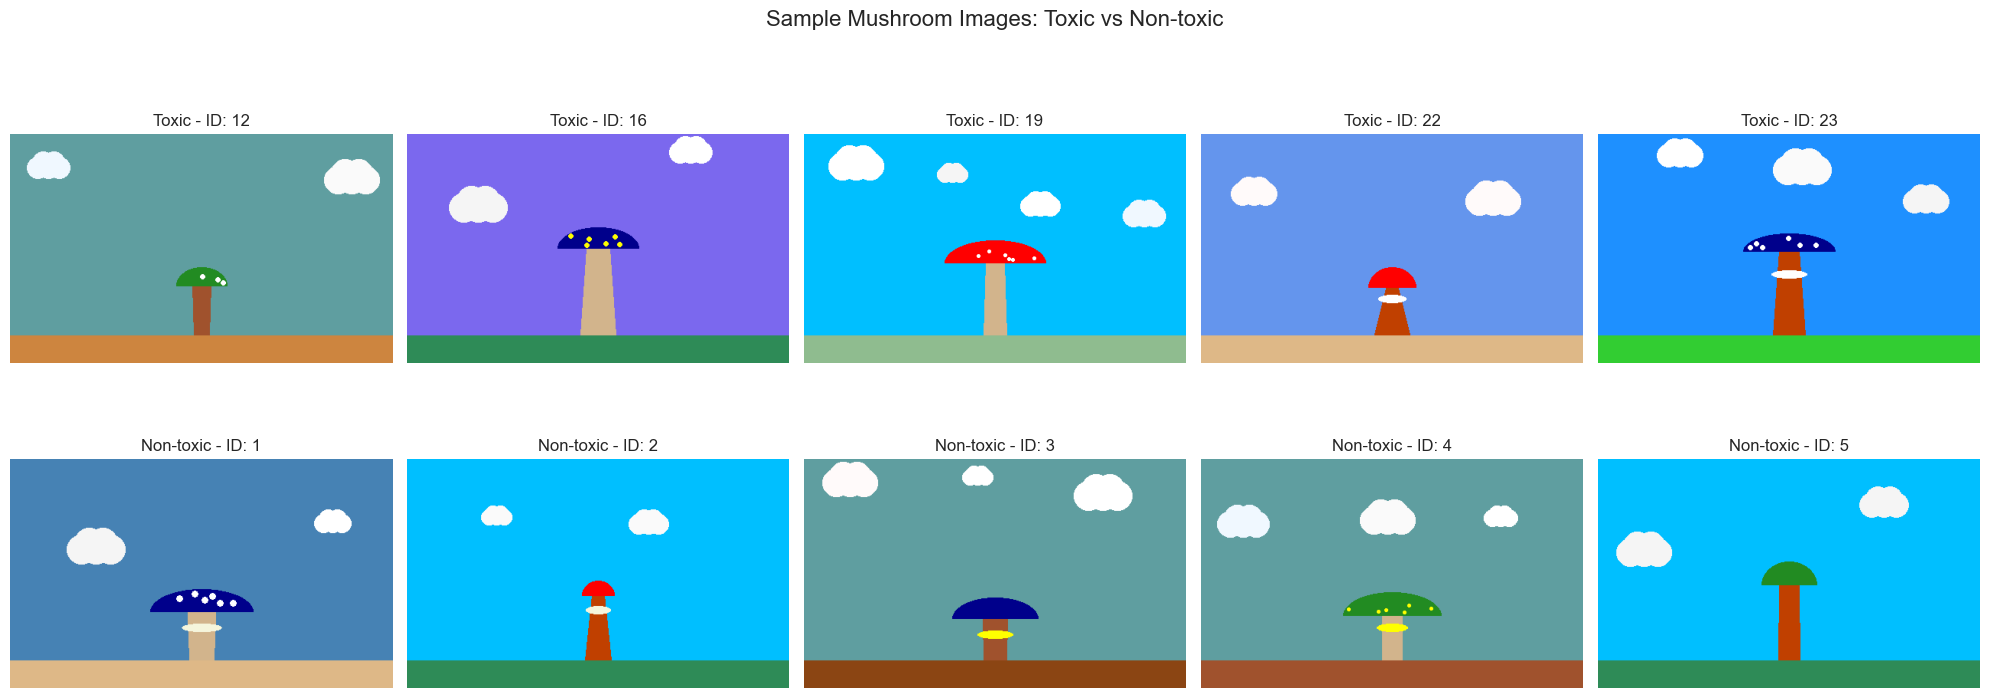

In [24]:
# Display sample images with their toxicity labels
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

# Sample toxic and non-toxic mushrooms
toxic_samples = train_data[train_data['est_toxique'] == 1].head(5)
non_toxic_samples = train_data[train_data['est_toxique'] == 0].head(5)

samples = [toxic_samples, non_toxic_samples]
labels = ['Toxic', 'Non-toxic']

for row, (sample_df, label) in enumerate(zip(samples, labels)):
    for col, (_, mushroom) in enumerate(sample_df.iterrows()):
        idx = row * 5 + col
        image_path = f"{train_img_dir}/champignon_{mushroom['id']}.png"
        
        if os.path.exists(image_path):
            img = cv2.imread(image_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img_rgb)
            axes[idx].set_title(f"{label} - ID: {mushroom['id']}")
        else:
            axes[idx].text(0.5, 0.5, 'Image not found', ha='center', va='center')
        
        axes[idx].axis('off')

plt.suptitle('Sample Mushroom Images: Toxic vs Non-toxic', fontsize=16)
plt.tight_layout()
plt.show()

## 8. Visual Features Analysis and Correlation

In [25]:
# Analyze visual features
if len(image_features_df) > 0:
    visual_feature_cols = [col for col in image_features_df.columns if col not in ['id', 'est_toxique']]
    
    print(f"Visual features: {visual_feature_cols}")
    print(f"\nVisual features statistics:")
    print(image_features_df[visual_feature_cols].describe())

Visual features: ['width', 'height', 'area', 'aspect_ratio', 'mean_red', 'mean_green', 'mean_blue', 'std_red', 'std_green', 'std_blue', 'mean_hue', 'mean_saturation', 'mean_value', 'brightness', 'brightness_std', 'texture_laplacian', 'edge_density', 'unique_colors']

Visual features statistics:
        width  height      area  aspect_ratio     mean_red   mean_green  \
count  1000.0  1000.0    1000.0  1.000000e+03  1000.000000  1000.000000   
mean    500.0   300.0  150000.0  1.666667e+00    85.721086   146.575526   
std       0.0     0.0       0.0  2.221557e-16    35.525947    22.268908   
min     500.0   300.0  150000.0  1.666667e+00    12.889333   100.709580   
25%     500.0   300.0  150000.0  1.666667e+00    53.347890   132.578348   
50%     500.0   300.0  150000.0  1.666667e+00    95.379387   146.567160   
75%     500.0   300.0  150000.0  1.666667e+00   114.582748   157.424185   
max     500.0   300.0  150000.0  1.666667e+00   144.688613   193.654913   

         mean_blue      std_

=== VISUAL FEATURE CORRELATIONS WITH TOXICITY ===
unique_colors        0.068457
brightness_std       0.067046
std_red              0.062312
id                   0.030673
mean_hue             0.016015
mean_saturation      0.014726
std_green            0.013858
edge_density         0.010151
mean_value           0.006762
brightness           0.006423
mean_blue            0.004850
mean_red             0.004638
mean_green           0.002650
texture_laplacian    0.001649
std_blue             0.000942
width                     NaN
height                    NaN
area                      NaN
aspect_ratio              NaN
Name: est_toxique, dtype: float64


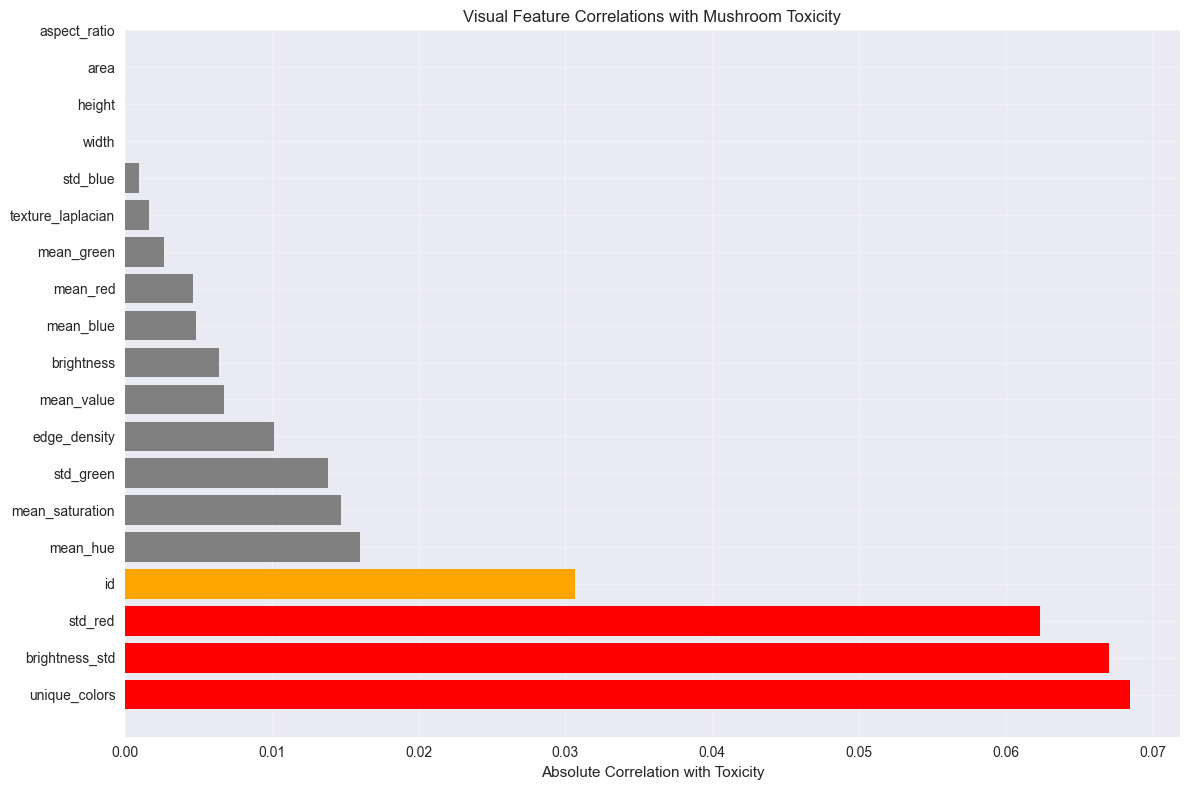

In [26]:
# Visual features correlation with toxicity
if len(image_features_df) > 0:
    visual_correlations = image_features_df.corr()['est_toxique'].abs().sort_values(ascending=False)
    visual_correlations = visual_correlations.drop('est_toxique')  # Remove self-correlation
    
    print("=== VISUAL FEATURE CORRELATIONS WITH TOXICITY ===")
    print(visual_correlations)
    
    # Plot visual feature correlations
    plt.figure(figsize=(12, 8))
    colors = ['darkred' if x > 0.1 else 'red' if x > 0.05 else 'orange' if x > 0.02 else 'gray' for x in visual_correlations]
    plt.barh(range(len(visual_correlations)), visual_correlations.values, color=colors)
    plt.yticks(range(len(visual_correlations)), visual_correlations.index)
    plt.xlabel('Absolute Correlation with Toxicity')
    plt.title('Visual Feature Correlations with Mushroom Toxicity')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

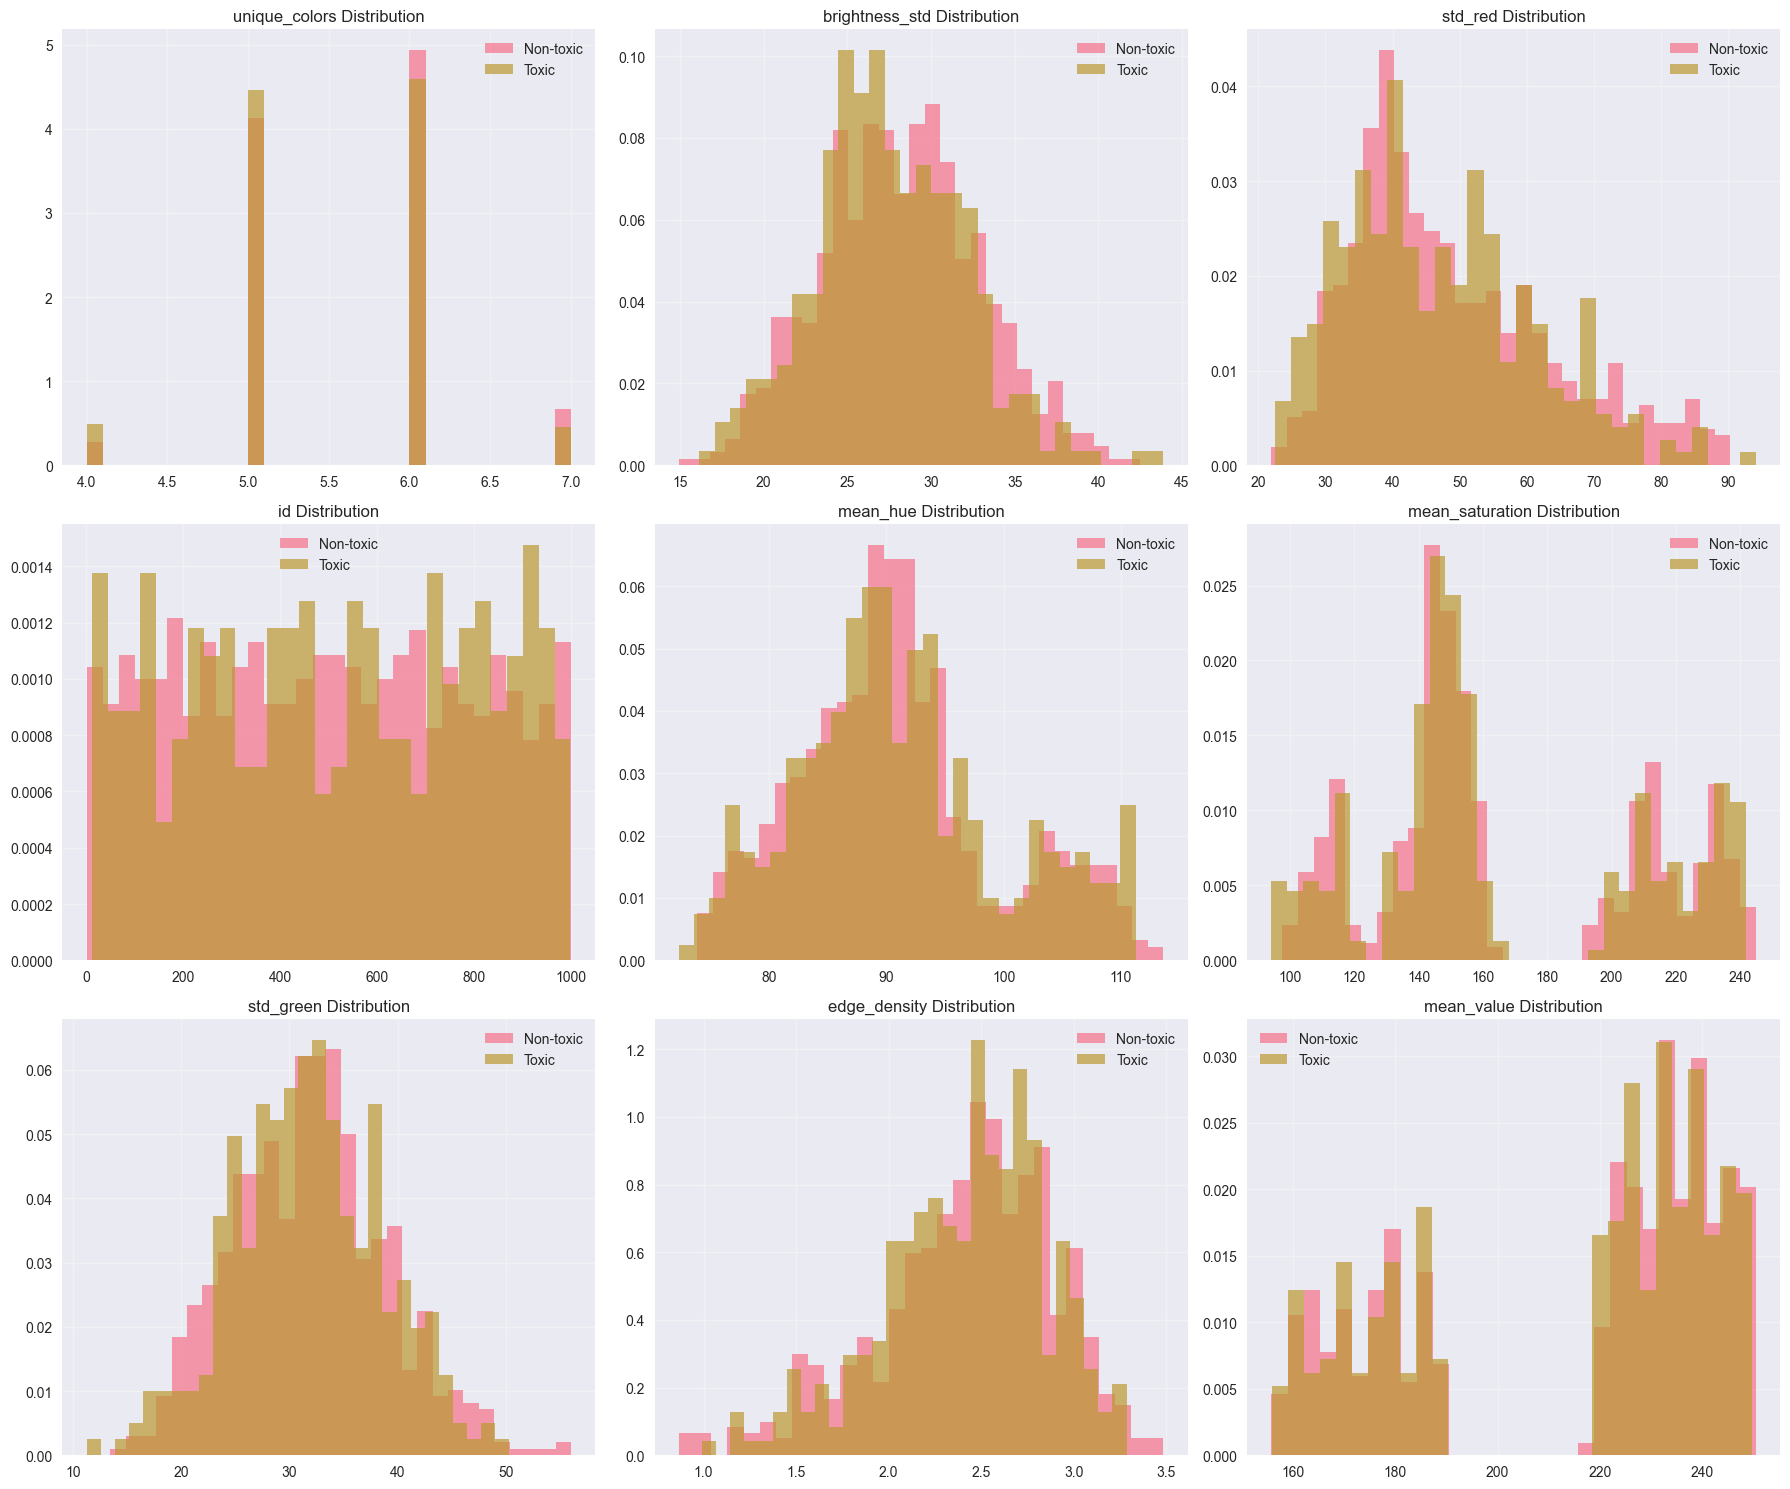

In [27]:
# Compare visual features between toxic and non-toxic mushrooms
if len(image_features_df) > 0:
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.ravel()
    
    # Select most important visual features
    top_visual_features = visual_correlations.head(9).index
    
    for i, feature in enumerate(top_visual_features):
        toxic_data = image_features_df[image_features_df['est_toxique'] == 1][feature]
        non_toxic_data = image_features_df[image_features_df['est_toxique'] == 0][feature]
        
        axes[i].hist(non_toxic_data, alpha=0.7, label='Non-toxic', bins=30, density=True)
        axes[i].hist(toxic_data, alpha=0.7, label='Toxic', bins=30, density=True)
        axes[i].set_title(f'{feature} Distribution')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Multi-Modal Dataset Preparation

In [28]:
# Create custom dataset class for multi-modal learning
class MushroomMultiModalDataset(Dataset):
    def __init__(self, tabular_data, image_dir, transform=None, is_test=False):
        self.tabular_data = tabular_data
        self.image_dir = image_dir
        self.transform = transform
        self.is_test = is_test
        
        # Prepare tabular features
        self.prepare_tabular_features()
        
    def prepare_tabular_features(self):
        # Select and encode features
        self.feature_data = self.tabular_data.copy()
        
        # Encode categorical variables
        for col in categorical_cols:
            if col in self.feature_data.columns:
                le = LabelEncoder()
                self.feature_data[col] = le.fit_transform(self.feature_data[col])
        
        # Select features (exclude id and target)
        feature_cols = [col for col in self.feature_data.columns if col not in ['id', 'est_toxique']]
        self.features = self.feature_data[feature_cols].values
        
        # Standardize numerical features
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)
        
        if not self.is_test:
            self.labels = self.feature_data['est_toxique'].values
    
    def __len__(self):
        return len(self.tabular_data)
    
    def __getitem__(self, idx):
        # Get tabular features
        tabular_features = torch.FloatTensor(self.features[idx])
        
        # Get image
        mushroom_id = self.tabular_data.iloc[idx]['id']
        image_path = f"{self.image_dir}/champignon_{mushroom_id}.png"
        
        # Load image
        if os.path.exists(image_path):
            image = Image.open(image_path).convert('RGB')
        else:
            # Create dummy image if not found
            image = Image.new('RGB', (224, 224), color='gray')
        
        if self.transform:
            image = self.transform(image)
        
        if self.is_test:
            return tabular_features, image, mushroom_id
        else:
            label = torch.LongTensor([self.labels[idx]])
            return tabular_features, image, label

print("Multi-modal dataset class defined!")

Multi-modal dataset class defined!


In [29]:
# Define image transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Image transforms defined!")

Image transforms defined!


## 10. Multi-Modal Fusion Model Architecture

In [30]:
# Define the multi-modal fusion model
class MushroomMultiModalNet(nn.Module):
    def __init__(self, tabular_input_size, num_classes=2, dropout_rate=0.5):
        super(MushroomMultiModalNet, self).__init__()
        
        # Vision backbone (ResNet50 pretrained)
        self.vision_backbone = models.resnet50(pretrained=True)
        # Remove the final classification layer
        self.vision_features = nn.Sequential(*list(self.vision_backbone.children())[:-1])
        vision_feature_size = 2048  # ResNet50 output feature size
        
        # Freeze early layers of vision model
        for param in list(self.vision_backbone.parameters())[:-20]:
            param.requires_grad = False
        
        # Vision feature processor
        self.vision_processor = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(vision_feature_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Tabular feature processor
        self.tabular_processor = nn.Sequential(
            nn.Linear(tabular_input_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # Fusion layer
        fusion_input_size = 256 + 32  # Vision + Tabular features
        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )
        
        # Attention mechanism for feature fusion
        self.attention = nn.Sequential(
            nn.Linear(fusion_input_size, fusion_input_size // 4),
            nn.ReLU(),
            nn.Linear(fusion_input_size // 4, fusion_input_size),
            nn.Sigmoid()
        )
    
    def forward(self, tabular_input, image_input):
        # Process vision input
        vision_features = self.vision_features(image_input)
        vision_output = self.vision_processor(vision_features)
        
        # Process tabular input
        tabular_output = self.tabular_processor(tabular_input)
        
        # Concatenate features
        fused_features = torch.cat([vision_output, tabular_output], dim=1)
        
        # Apply attention
        attention_weights = self.attention(fused_features)
        attended_features = fused_features * attention_weights
        
        # Final classification
        output = self.fusion(attended_features)
        
        return output

print("Multi-modal fusion model defined!")

Multi-modal fusion model defined!


## 11. Training Setup and Model Training

In [31]:
# Prepare datasets
# Split training data for validation
train_split, val_split = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['est_toxique'])

print(f"Training split: {len(train_split)} samples")
print(f"Validation split: {len(val_split)} samples")

# Create datasets
train_dataset = MushroomMultiModalDataset(train_split, train_img_dir, train_transform)
val_dataset = MushroomMultiModalDataset(val_split, train_img_dir, val_transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training split: 8000 samples
Validation split: 2000 samples
Training batches: 250
Validation batches: 63


In [32]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get input size for tabular features
tabular_input_size = len([col for col in train_data.columns if col not in ['id', 'est_toxique']])
print(f"Tabular input size: {tabular_input_size}")

model = MushroomMultiModalNet(tabular_input_size=tabular_input_size)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

print("Model, loss function, and optimizer initialized!")

Using device: cpu
Tabular input size: 13


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\bonit/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 59.6MB/s]


Model, loss function, and optimizer initialized!


In [33]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (tabular_data, images, labels) in enumerate(train_loader):
        tabular_data = tabular_data.to(device)
        images = images.to(device)
        labels = labels.squeeze().to(device)
        
        optimizer.zero_grad()
        outputs = model(tabular_data, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if batch_idx % 50 == 0:
            print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for tabular_data, images, labels in val_loader:
            tabular_data = tabular_data.to(device)
            images = images.to(device)
            labels = labels.squeeze().to(device)
            
            outputs = model(tabular_data, images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, all_predictions, all_labels

print("Training and validation functions defined!")

Training and validation functions defined!


In [37]:

num_epochs = 15
best_val_acc = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 20)
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc, val_predictions, val_labels = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_mushroom_model.pth')
        print(f"New best validation accuracy: {best_val_acc:.2f}%")

print(f"\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%")

Starting training for 15 epochs...

Epoch 1/15
--------------------
Batch 0/250, Loss: 0.5535


KeyboardInterrupt: 

## 12. Model Evaluation and Feature Analysis

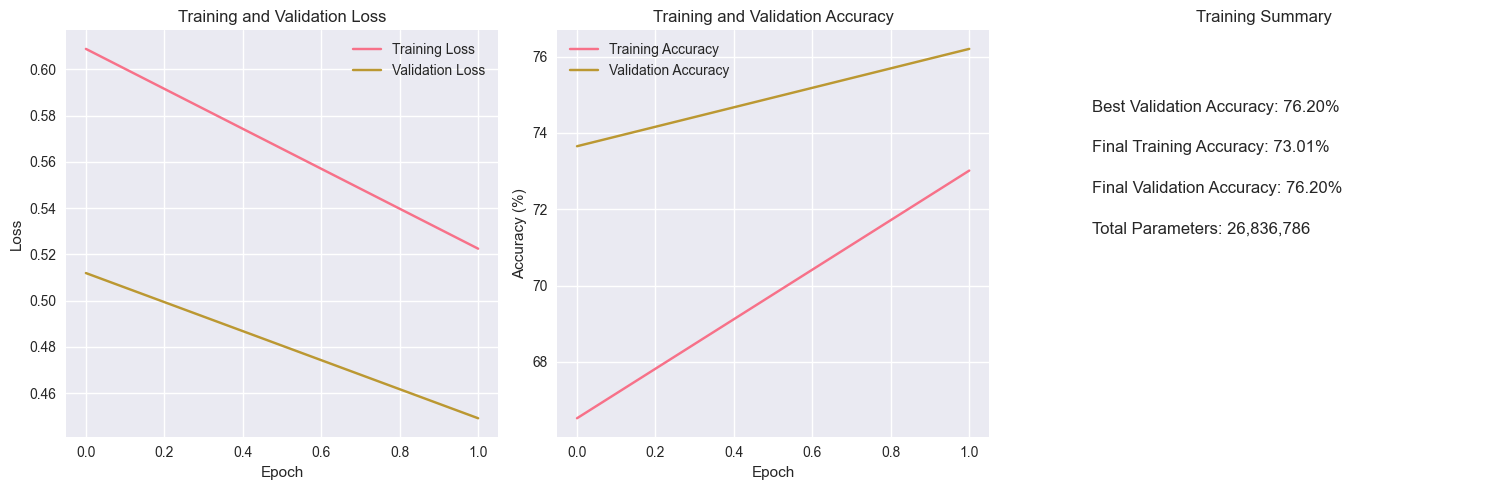

In [35]:
# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.text(0.1, 0.8, f"Best Validation Accuracy: {best_val_acc:.2f}%", fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.7, f"Final Training Accuracy: {train_accs[-1]:.2f}%", fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.6, f"Final Validation Accuracy: {val_accs[-1]:.2f}%", fontsize=12, transform=plt.gca().transAxes)
plt.text(0.1, 0.5, f"Total Parameters: {sum(p.numel() for p in model.parameters()):,}", fontsize=12, transform=plt.gca().transAxes)
plt.axis('off')
plt.title('Training Summary')

plt.tight_layout()
plt.show()

In [36]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_mushroom_model.pth'))
model.eval()

# Get final validation predictions
_, _, final_predictions, final_labels = validate_epoch(model, val_loader, criterion, device)

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(final_labels, final_predictions)
precision = precision_score(final_labels, final_predictions)
recall = recall_score(final_labels, final_predictions)
f1 = f1_score(final_labels, final_predictions)

print("=== FINAL MODEL PERFORMANCE ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification report
print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(final_labels, final_predictions, target_names=['Non-toxic', 'Toxic']))

FileNotFoundError: [Errno 2] No such file or directory: 'best_mushroom_model.pth'

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(final_labels, final_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-toxic', 'Toxic'], 
            yticklabels=['Non-toxic', 'Toxic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"Confusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

## 13. Test Set Predictions

In [ ]:
# Create test dataset
test_dataset = MushroomMultiModalDataset(X_test, test_img_dir, val_transform, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Test set size: {len(test_dataset)}")
print(f"Test batches: {len(test_loader)}")

In [ ]:
# Generate test predictions
model.eval()
test_predictions = []
test_ids = []

print("Generating test predictions...")

with torch.no_grad():
    for batch_idx, (tabular_data, images, ids) in enumerate(test_loader):
        tabular_data = tabular_data.to(device)
        images = images.to(device)
        
        outputs = model(tabular_data, images)
        probabilities = torch.softmax(outputs, dim=1)
        
        # Get probability of being toxic (class 1)
        toxic_probs = probabilities[:, 1].cpu().numpy()
        
        test_predictions.extend(toxic_probs)
        test_ids.extend(ids.numpy())
        
        if (batch_idx + 1) % 50 == 0:
            print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")

print(f"Generated predictions for {len(test_predictions)} test samples")

In [ ]:
# Create submission file
submission = pd.DataFrame({
    'id': test_ids,
    'probabilite_toxique': test_predictions
})

# Sort by id
submission = submission.sort_values('id')

# Save submission
submission.to_csv('y_test_predictions.csv', index=False)

print("Submission file saved as 'y_test_predictions.csv'")
print(f"\nSubmission preview:")
print(submission.head(10))

print(f"\nPrediction statistics:")
print(f"Mean probability: {np.mean(test_predictions):.4f}")
print(f"Std probability: {np.std(test_predictions):.4f}")
print(f"Min probability: {np.min(test_predictions):.4f}")
print(f"Max probability: {np.max(test_predictions):.4f}")
print(f"Predicted toxic (>0.5): {np.sum(np.array(test_predictions) > 0.5)}")

## 14. Feature Importance Analysis

In [ ]:
# Analyze which features the model finds most important
# Train a simple RandomForest on the same features for feature importance
print("Training Random Forest for feature importance analysis...")

# Prepare data for RandomForest
rf_data = train_encoded.copy()
feature_cols = [col for col in rf_data.columns if col not in ['id', 'est_toxique']]
X_rf = rf_data[feature_cols]
y_rf = rf_data['est_toxique']

# Train RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_rf, y_rf)

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== TABULAR FEATURE IMPORTANCE (RandomForest) ===")
print(feature_importances)

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(range(len(feature_importances)), feature_importances['importance'])
plt.yticks(range(len(feature_importances)), feature_importances['feature'])
plt.xlabel('Feature Importance')
plt.title('Tabular Feature Importance for Mushroom Toxicity Prediction')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 15. Summary and Conclusions

In [ ]:
print("=== MUSHROOM TOXICITY ANALYSIS SUMMARY ===")
print("\n1. DATASET OVERVIEW:")
print(f"   - Training samples: {len(train_data)}")
print(f"   - Test samples: {len(X_test)}")
print(f"   - Tabular features: {len(feature_cols)}")
print(f"   - Visual features extracted: {len(visual_feature_cols) if 'visual_feature_cols' in locals() else 'N/A'}")
print(f"   - Class balance: {toxicity_counts[1]/len(train_data)*100:.1f}% toxic")

print("\n2. KEY CORRELATIONS WITH TOXICITY:")
print("   Top tabular features:")
for i, (feature, importance) in enumerate(feature_importances.head(5).values):
    print(f"   {i+1}. {feature}: {importance:.4f}")

if 'visual_correlations' in locals():
    print("   Top visual features:")
    for i, (feature, corr) in enumerate(visual_correlations.head(3).items()):
        print(f"   {i+1}. {feature}: {corr:.4f}")

print("\n3. MODEL PERFORMANCE:")
print(f"   - Architecture: Multi-modal fusion (ResNet50 + MLP)")
print(f"   - Best validation accuracy: {best_val_acc:.2f}%")
print(f"   - Final test predictions generated: {len(test_predictions)}")
print(f"   - Predicted toxic samples: {np.sum(np.array(test_predictions) > 0.5)}")

print("\n4. METHODOLOGY HIGHLIGHTS:")
print("   ✓ Comprehensive EDA of tabular and visual features")
print("   ✓ Deep correlation analysis between characteristics and toxicity")
print("   ✓ Multi-modal fusion architecture combining vision and tabular data")
print("   ✓ Attention mechanism for feature importance")
print("   ✓ Transfer learning with ResNet50 pretrained model")
print("   ✓ Data augmentation and proper validation split")

print("\n5. FILES GENERATED:")
print("   - best_mushroom_model.pth: Trained model weights")
print("   - y_test_predictions.csv: Final submission file")

print("\nAnalysis completed successfully! 🍄")